### Paper Novelty Detection

##### By Jingting Zhang

## Question:
Given a recently published paper (from 2016 onwards), is there a set of papers from 1990-2015 that are closely related to it?

## Introduction
To address this question, I mainly focused on the abstracts of papers, which carries rich information that summarizes the papers. 

To explore the data set, I first employed the topic modeling technique LDA to explore the topics of the training datasets. I then applied the trained LDA model onto the testing dataset to examine the similarity of topics across the two datasets.

By employing the word embedding model word2vec, I converted all the abstract texts into vectors of 300 features each. I then conducted a K-means clustering analysis on all the abstract vectors. The combination of the word embedding and the clustering methods allowed me to extract various semantic categories the papers belong to. The number of clusters used in the analysis was in consistency with the pre-defined number of topics used in the LDA topic modeling.

Next I conducted a PCA analysis to reduce the dimentionality of the 300-dimensional abstract vector space down to 3 components. The K-Means labels previously obtained were used to visualize the distributions of the papers across different PCA components. I validated my approach by applying the PCA and K-Means modeling to the validation dataset to visually verify the goodness of the clusters.

Finally, I picked a random paper from the testing dataset and checked whether there is a set of papers from the training dataset that are closely related. To do that, I calculated the similarity score between the example paper and all other papers that belong to the same KMeans cluster. I was specifically interested in those papers with a similarity score greater or equal to 0.90.

My pipeline is listed below.

### Pipeline

- **Get data ready**: Data import and visualization
- __Data exploration__
  -- Topic modelling using LDA: Three topics were pre-defined (training and testing data)
- **_Word2vec_**: Used a pre-trained model for converting each abstract in the training and testing dataset into vectors
- __Kmeans clustering__: 
  - Used to cluster the paper abstracts in the training dataset into different categories (training data)
  - Predicted the testing data based on the K-means model from the training dataset (testing data)
- __PCA__
  - Reduced the data dimentionality from 300 features to 3 PCA components (training data)
  - Validated the model by applying the same PCA transformation from the training dataset to the testing and validation datasets (testing & validation data)
  - Plotted the data across the PCA components using K-means labels
- __Similarity scores__
  - Calculated the cosine similarity scores between a randomly selected paper and all other papers within the same K-means cluster 
  - Identified whether there is a set of papers that show close semantic similarity with the given paper

## 1. Data import and visualization

In [89]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
import pickle
import sklearn
import random

import nltk
import nltk.classify.util
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as wn
from keras.preprocessing.text import Tokenizer

import gensim
from gensim import corpora
import pyLDAvis.gensim # Please install the pyldavis package if needed: conda install -c conda-forge pyldavis
import multiprocessing
from scipy import spatial

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Function to import data into a dataframe format
def importdata(path):
    with open(path) as f:
        data = json.loads(f.read())
    df = pd.DataFrame.from_dict(data)
    return df

In [3]:
df_train = importdata('data_train.json')
df_train.head(2)

,abstract,authors,day,month,tags,title,year
0,Learned feature representations and sub-phonem...,"[{'name': 'Fred Richardson'}, {'name': 'Dougla...",3,4,"[cs.CL, cs.CV, cs.LG, cs.NE, stat.ML]",A Unified Deep Neural Network for Speaker and ...,2015
1,We propose a simple neural network model to de...,"[{'name': 'Muhammad Ghifary'}, {'name': 'W. Ba...",21,9,"[cs.CV, cs.AI, cs.LG, cs.NE, stat.ML]",Domain Adaptive Neural Networks for Object Rec...,2014


In [4]:
print(len(df_train))

19306


In [5]:
df_train['abstract'][0]

'Learned feature representations and sub-phoneme posteriors from Deep Neural Networks (DNNs) have been used separately to produce significant performance gains for speaker and language recognition tasks. In this work we show how these gains are possible using a single DNN for both speaker and language recognition. The unified DNN approach is shown to yield substantial performance improvements on the the 2013 Domain Adaptation Challenge speaker recognition task (55% reduction in EER for the out-of-domain condition) and on the NIST 2011 Language Recognition Evaluation (48% reduction in EER for the 30s test condition).'

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


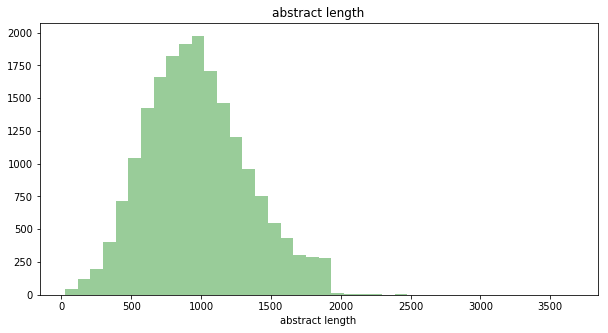

In [6]:
# Visualize the length of the abstracts in the training data
df_train['abstract length'] = df_train['abstract'].astype(str).apply(len)

plt.figure(figsize = (10, 5))
sns.distplot(df_train['abstract length'], color = 'green', bins = 40, kde = False)
plt.title('abstract length')
plt.savefig('plot of abstract length.png')

In [7]:
print(min(df_train['abstract length'])); print(max(df_train['abstract length']))

25
3658


## 2. Topic modelling using LDA (Data exploration)

### 2.1. Pre-processing of abstract texts: convert to lower case, remove stopwords, tokenization, and lemmatization.

In [9]:
tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}')

In [10]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jingtingzhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Create Function to convert text to lower case, remove stopwords, and tokenization
def preprocessing(df):
    df['abstract tokenized'] = df['abstract'].astype(str).str.lower()
    df['abstract tokenized'] = df.apply(lambda row: tokenizer.tokenize(row['abstract tokenized']), axis=1)
    df['abstract tokenized'] = df['abstract tokenized'].apply(lambda x: [w for w in x if not w in stop_words]) 

In [12]:
preprocessing(df_train)

###### Wordnet lemmatizer: lemmatize the abstract texts

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jingtingzhang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
def create_lemma1(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma    

from nltk.stem.wordnet import WordNetLemmatizer
def create_lemma2(word):
    return WordNetLemmatizer().lemmatize(word, 'v')

def create_lemma(word):
    word1 = create_lemma1(word)
    word2 = create_lemma2(word1)
    return word2

In [15]:
def create_lemma_abstract(abstract):
    lem_words = []
    for word in abstract:
        lem_words.append(create_lemma(word)) 
    return(lem_words) 

In [16]:
def create_lemma_all_abstract(df):
    lem_abstract = []
    abstract = df['abstract tokenized']
    for text in (abstract):
        lem_abstract.append(create_lemma_abstract(text))
    df['lem abstract'] = lem_abstract

In [17]:
create_lemma_all_abstract(df_train)

In [18]:
text_data_train = df_train['lem abstract']

### 2.2 LDA analysis looking for topics across all the abstracts of the research papers

In this section, I conducted an LDA analysis to extract 3 topics in the training dataset. This allowed me to gain a qualitative understanding of the topics covered by the research papers published from 1995-2015.

In [19]:
# Create a dictionary from the data, convert to bag-of-words corpus and save the dictionary and corpus for future use
dictionary = corpora.Dictionary(text_data_train)
corpus = [dictionary.doc2bow(txt) for txt in text_data_train]

In [20]:
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

In [25]:
# Build the LDA model to look for 5 topics in the training data
NUM_TOPICS = 3
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5_train.gensim')
topics = ldamodel.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.021*"algorithm" + 0.014*"problem" + 0.012*"method" + 0.011*"model" + 0.011*"learn" + 0.010*"data"')
(1, '0.011*"system" + 0.011*"use" + 0.010*"model" + 0.007*"paper" + 0.007*"base" + 0.007*"problem"')
(2, '0.022*"image" + 0.016*"use" + 0.012*"method" + 0.010*"feature" + 0.010*"propose" + 0.009*"base"')


From the above output from the LDA analysis, we conclude that the topics of the research papers (1995-2015) are very similar to each other - mainly related to data modeling, but the 3rd topic seems to have a focus on imaging processing in particular.


In [26]:
# Visualize the 5 topics, with each circle in the figure on the left showing each topic
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5_train.gensim')
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


### 2.3 Use the training-based topic modeling (LDA) to predict testing data

#### 2.3.1 Import testing data, visualize, and preprocessing

In [29]:
df_test = importdata('data_test.json')
df_test.head(2)

,abstract,authors,day,month,tags,title,year
0,"In recent years, deep neural network exhibits ...","[{'name': 'Aosen Wang'}, {'name': 'Hua Zhou'},...",16,8,[cs.CV],Deep Neural Network Capacity,2017
1,This paper introduces the visually informed em...,"[{'name': 'Oswaldo Ludwig'}, {'name': 'Xiao Li...",28,3,"[cs.CL, cs.CV, cs.LG, cs.NE]",Deep Embedding for Spatial Role Labeling,2016


/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


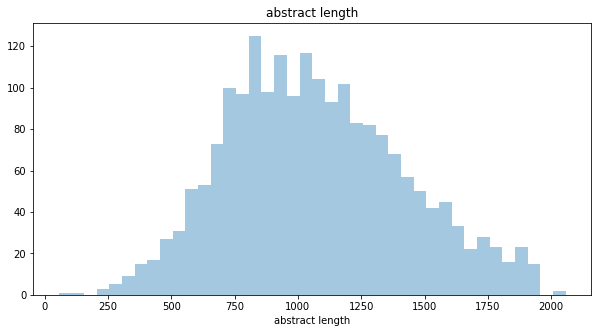

In [32]:
df_test['abstract length'] = df_test['abstract'].astype(str).apply(len)

plt.figure(figsize = (10, 5))
sns.distplot(df_test['abstract length'], bins = 40, kde = False)
plt.title('abstract length')
plt.savefig('plot of test abstract length.png')

In [35]:
preprocessing(df_test)
create_lemma_all_abstract(df_test)

text_data_test = df_test['lem abstract']

In [36]:
data_test_bow = [dictionary.doc2bow(txt) for txt in text_data_test]
ldamodel.get_document_topics(data_test_bow)
list(ldamodel.get_document_topics(data_test_bow))

[[(0, 0.29942077), (1, 0.15632387), (2, 0.5442553)],
 [(1, 0.013801836), (2, 0.9817466)],
 [(0, 0.7207381), (1, 0.27242514)],
 [(0, 0.54357255), (2, 0.45019734)],
 [(0, 0.022472236), (1, 0.8772341), (2, 0.100293666)],
 [(0, 0.97854936), (2, 0.015016763)],
 [(1, 0.27942583), (2, 0.7172243)],
 [(2, 0.99110526)],
 [(0, 0.1112452), (2, 0.88314694)],
 [(0, 0.1390637), (1, 0.012776886), (2, 0.84815943)],
 [(0, 0.91389287), (1, 0.08223057)],
 [(1, 0.5270669), (2, 0.46497113)],
 [(2, 0.993525)],
 [(0, 0.19034226), (2, 0.8069969)],
 [(1, 0.54109377), (2, 0.45452997)],
 [(0, 0.18479176), (1, 0.18446991), (2, 0.6307384)],
 [(0, 0.19696291), (1, 0.100669205), (2, 0.70236784)],
 [(0, 0.85027194), (1, 0.10338514), (2, 0.046342913)],
 [(0, 0.7120238), (1, 0.28412908)],
 [(1, 0.31231102), (2, 0.683851)],
 [(0, 0.448681), (2, 0.5485799)],
 [(0, 0.34016514), (2, 0.65577275)],
 [(0, 0.2988621), (1, 0.0306187), (2, 0.6705192)],
 [(0, 0.1387343), (2, 0.8538553)],
 [(0, 0.09325949), (1, 0.20375031), (2, 0.7

In [37]:
lda_display = pyLDAvis.gensim.prepare(lda, data_test_bow, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


**Summary of the LDA prediction of the testing data:**
As we can tell by comparing the topic output from the training dataset and the same model that was applied to predict the testing dataset,
the research papers in the testing dataset fit the 3 topics obtained from the training dataset, suggesting that the recently published
topics (topic 3) compared to the earlier papers.

--------------------

## 3. Use word2vec to vectorize each abstract

In this section, I converted each word in the abstract into a vector containing 300 dimensions and calculated a vector for each abstract by averaging across all the word vectors within each abstract. The output of the word2vec analysis will be used for K-Means and PCA analysis later.

In [41]:
import warnings
warnings.filterwarnings(action='once')

In [42]:
# Used a pre-trained dataset for word2vec analysis
model_location = '/Users/jingtingzhang/Documents/jobapp_2019/Georgian_Partners/Data challenge/'
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000)

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/gensim/models/utils_any2vec.py:214: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  weights = fromstring(fin.read(binary_len), dtype=REAL).astype(datatype)


In [47]:
# Created function to convert each abstract into a 300-dimensional vector
def abstract_to_vector(model, abstract):
    num_features = 300 
    single_abstract = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in abstract:
        if word in model.vocab:
            single_abstract = np.add(single_abstract, model[word])
            n_words += 1
    single_abstract = single_abstract/n_words
    return single_abstract

In [49]:
# Generate vetors for all the abstracts in the training dataset
avg_abstract = []
for abstract in df_train['lem abstract']:
    avg_abstract.append(list(abstract_to_vector(model, abstract)))
df_train['avg abstract'] = avg_abstract

## 4. K-means Clustering of the abstracts based on word2vec output (training dataset)

I then used K-means method to cluster the unlabelled abstracts into different categories. Considering that we predefined 3 topics in the LDA model, here I also focus on 3 clusters to keep consistency.

In [50]:
X_train = []
for i in range(len(df_train)):
    X_train.append(df_train['avg abstract'][i])

In [53]:
model_train_kmeans = KMeans(n_clusters=3, random_state=0).fit(X_train)

In [54]:
df_train['kmeans label'] = model_train_kmeans.labels_

I calculated the Silhouette score to confirm that there was no clear clustering of the training data.

In [62]:
score = sklearn.metrics.silhouette_score(X_train, model_train_kmeans.labels_, metric = 'euclidean')
print(score)

/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


0.03147187


**Summary of the K-means clustering analysis**:
The results showed that there does not seem to be clear clusters that are well separated for the training dataset.

------------

## 5. PCA (training dataset)

Here I reduced the dimensionality of the vectors for each abstract from 300 vectors to 3 components and plotted the training data based on the k-means labels generated from the previous section.

In [63]:
pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train)
print(pca.explained_variance_ratio_)

[0.07094158 0.0462674  0.04369797]


In [64]:
df_train_pca = pd.DataFrame(X_train_pca, columns = ['PCA1', 'PCA2', 'PC3'])
df_train_pca['kmeans labels'] = model_train_kmeans.labels_

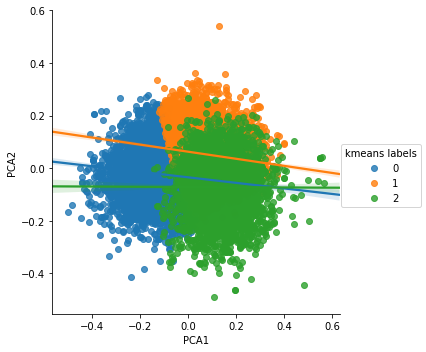

In [65]:
sns.lmplot(x = 'PCA1', y='PCA2', data = df_train_pca, hue = 'kmeans labels')

**Summary of the PCA results**:
The PCA analysis did not seem to have shown a clear separation of components among the training data. In combination of the K-Means analysis, these results may suggest no clear clustering of the research papers from 1995-2015, in consistency with the LDA results reported previously. 

--------------

## 6. Use k-means to predict testing data

I then used the K-means model built out of the training data to predict the testing data, to examine whether the testing data shows similar clustering patterns as the training data.

In [66]:
avg_abstract2 = []
for abstract in df_test['lem abstract']:
    avg_abstract2.append(list(abstract_to_vector(model, abstract)))
df_test['avg abstract'] = avg_abstract2

In [67]:
X_test = []
for i in range(len(df_test)):
    X_test.append(df_test['avg abstract'][i])

model_test_kmeans = model_train_kmeans.predict(X_test)
model_test_kmeans

array([1, 2, 1, ..., 1, 0, 1], dtype=int32)

In [68]:
X_pcatest = pca.transform(X_test)
X_pcatest

array([[-0.02554213,  0.04740448, -0.05011267],
       [-0.02065694,  0.08773936,  0.18109742],
       [-0.05235932, -0.00391419, -0.12543999],
       ...,
       [ 0.06402928,  0.05203345, -0.01159516],
       [-0.18031812,  0.13251447, -0.07485289],
       [ 0.03463067,  0.10267536, -0.04472861]])

In [70]:
df_test_pca = pd.DataFrame(X_pcatest, columns = ['PCA1', 'PCA2', 'PC3'])
df_test_pca.head()

,PCA1,PCA2,PC3
0,-0.025542,0.047404,-0.050113
1,-0.020657,0.087739,0.181097
2,-0.052359,-0.003914,-0.125440
3,0.115490,-0.026442,-0.037948
4,0.246483,-0.098636,0.017215


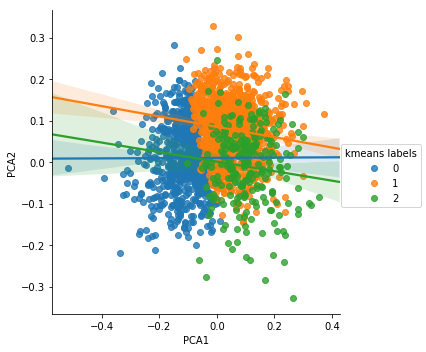

In [71]:
df_test_pca['kmeans labels'] = model_test_kmeans
sns.lmplot(x = 'PCA1', y='PCA2', data = df_test_pca, hue = 'kmeans labels')

I then calculated the Silhouette score to independently confirm that there was no clear clustering of the testing data.

In [73]:
score_test = sklearn.metrics.silhouette_score(X_test, model_test_kmeans, metric = 'euclidean')
print(score_test)

0.03826164


/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


**Summary of the prediction results using K-means**:
The results revealed no clear clustering of the research papers published from 2016 onward either, in consistency with the LDA results reported previously as well. 

------------

## 7. Use K-means to conduct validation

### 7.1 Import validation data, visualize, and preprocessing

In [74]:
df_valid = importdata('data_valid.json')
df_valid.head(2)

,abstract,authors,day,month,tags,title,year
0,"Real-time, accurate, and robust pupil detectio...","[{'name': 'Thiago Santini'}, {'name': 'Wolfgan...",24,12,"[cs.CV, cs.HC]",PuRe: Robust pupil detection for real-time per...,2017
1,Diabetic Foot Ulcer (DFU) is a major complicat...,"[{'name': 'Manu Goyal'}, {'name': 'Neil D. Ree...",6,8,[cs.CV],Fully Convolutional Networks for Diabetic Foot...,2017


/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


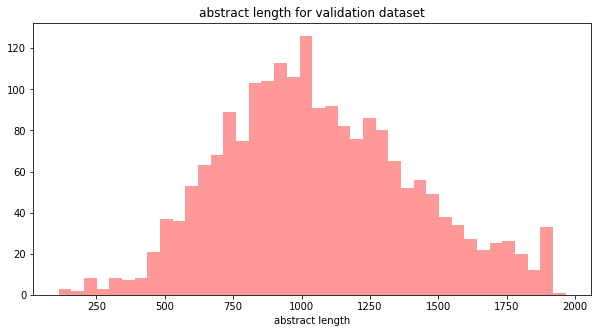

In [75]:
df_valid['abstract length'] = df_valid['abstract'].astype(str).apply(len)

plt.figure(figsize = (10, 5))
sns.distplot(df_valid['abstract length'], color = 'red', bins = 40, kde = False)
plt.title('abstract length for validation dataset')
plt.savefig('plot of validation abstract length.png')

In [76]:
preprocessing(df_valid)
create_lemma_all_abstract(df_valid)

In [77]:
avg_abstract3 = []
for abstract in df_valid['lem abstract']:
    avg_abstract3.append(list(abstract_to_vector(model, abstract)))
df_valid['avg abstract'] = avg_abstract3

In [78]:
X_valid = []
for i in range(len(df_valid)):
    X_valid.append(df_valid['avg abstract'][i])

model_valid_kmeans = model_kmeans.predict(X_valid)
model_valid_kmeans

array([1, 1, 0, ..., 0, 0, 1], dtype=int32)

In [79]:
X_pcavalid = pca.transform(X_valid)
X_pcavalid

array([[-0.01219424,  0.09237211, -0.10257519],
       [ 0.03631204,  0.10006301, -0.16460424],
       [-0.10462466,  0.14281442, -0.1118783 ],
       ...,
       [-0.20406222,  0.16980263,  0.02981044],
       [-0.09878501,  0.02991731, -0.03950298],
       [-0.00314757,  0.12443685,  0.08065594]])

In [80]:
df_valid_pca = pd.DataFrame(X_pcavalid, columns = ['PCA1', 'PCA2', 'PC3'])
df_valid_pca.head()

,PCA1,PCA2,PC3
0,-0.012194,0.092372,-0.102575
1,0.036312,0.100063,-0.164604
2,-0.104625,0.142814,-0.111878
3,0.118016,0.130141,-0.028443
4,-0.161678,0.044264,-0.058438


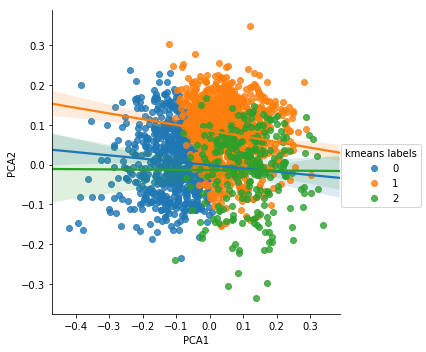

In [81]:
df_valid_pca['kmeans labels'] = model_valid_kmeans
sns.lmplot(x = 'PCA1', y='PCA2', data = df_valid_pca, hue = 'kmeans labels')

In [83]:
score_valid = sklearn.metrics.silhouette_score(X_valid, model_valid_kmeans, metric = 'euclidean')
print(score_valid)

0.038824853


/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


**Summary of the validation results using K-means**:
Simiar to the prediction model, the validation model confirmed no clear clustering of the recent research papers. 

--------

## 8. Calculate cosine similarity scores between one abstract and other abstracts

Here with an example, I would like to show that given a certain research paper that is recently published, whether there is a set of earlier papers from 1995-2015 that are closely related to it. 

I first targeted a set of paper that are in the same cluster as the example recent paper. Next I calculated the cosine similarity scores between the example paper and all other papers in the same cluster. Based on the similarity scores, I set a cutoff of 0.90 to select those papers from 1995-2015 that are closely related to the example paper. 

In [100]:
# # Randomly select a recent research paper
# int(random.random()*len(df_test['avg abstract'])) # # This line is commented out for now.

156

In [102]:
# Select a research paper published in recent years (2016 onward)
recent_paper = df_test['avg abstract'][156]

In [103]:
# Locate the cluster that the selected recent paper belongs to
model_train_kmeans.predict([recent_paper])

array([2], dtype=int32)

In [105]:
# Choose all the research papers that are in the same cluster as the selected paper
target_set = df_train[df_train['kmeans label'] == 2][['abstract', 'avg abstract', 'kmeans label']]
target_set.head(2)

,abstract,avg abstract,kmeans label
3,"In this paper, we address the task of Optical ...","[0.019558856, 0.008803719, -0.011499279, 0.091...",2
9,We present a novel response generation system ...,"[0.050525926, -0.019018585, -0.014935662, 0.08...",2


In [106]:
def similarity(recent_paper, target):
    return 1-spatial.distance.cosine(recent_paper, target)

In [107]:
sim = []
for doc in target_set['avg abstract']:
    sim_score = similarity(recent_paper, doc)
    sim.append(sim_score)
target_set['sim_scores'] = sim

In [112]:
# Cutoff was 0.90 for choosing the closely related papers from 1995-2015
sorted_target_set = target_set.sort_values(by = ['sim_scores'], ascending = False)
closely_related_target_set = sorted_target_set[sorted_target_set['sim_scores'] > 0.90]
print(len(sorted_target_set[sorted_target_set['sim_scores'] > 0.90]))

41


/Users/jingtingzhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


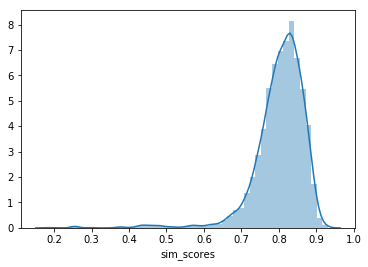

In [113]:
sns.distplot(sorted_target_set['sim_scores'])

## **Summary of Results**:
### My results have shown that given a paper published in recent years (2016 onwards), take the 156th paper for example, there were 41 research papers published from 1995-2015 that are closely related to it.

__END__